In [1]:
%matplotlib inline

In [78]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table

In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
mcfitter.sigma

array([0.1       , 0.1       , 0.1       , 4.        , 1.04719755,
       0.52359878])

In [84]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])

#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [305]:
#evt_ID = 228
#full = pytpc.HDFDataFile('/home/chen/Real Data/run_0085.h5', 'r') 
#print(len(full))
#evt_full = full[evt_ID]
#xyzs = evt_full.xyzs(peaks_only=True, drift_vel=-2.54, clock=12.5, return_pads=True, baseline_correction=True, cg_times=True)
#cx = 0. #The center of curvature of the track, in mm.
#cy = 0.

evt_ID = 240 #Good events are: 228, 240, 258, 459
full = pytpc.HDFDataFile('/home/chen/Real Data/run_0085.h5', 'r') 
evt_full = full[evt_ID]
xyzs = evt_full.xyzs(peaks_only=True, drift_vel=-2.54, clock=12.5, return_pads=True, baseline_correction=True, cg_times=True)
cx = 0. #The center of curvature of the track, in mm.
cy = 0.
#print(xyzs)

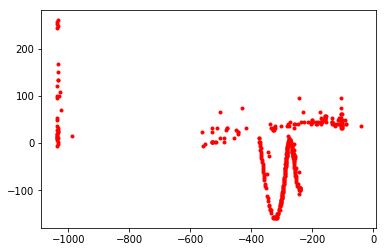

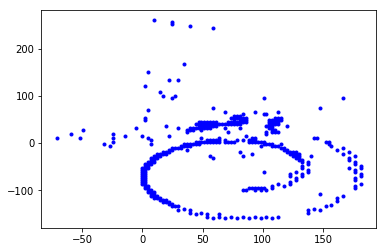

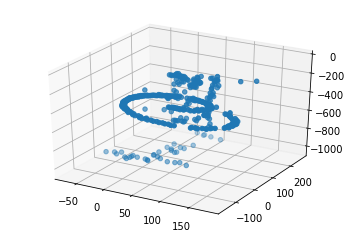

In [306]:
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'b.')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyzs[:,0],xyzs[:,1],xyzs[:,2])

In [315]:
xyz, (cu, cv) = mcfitter.preprocess(xyzs, center=(cx, cy))
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(xyz, cu, cv, return_details=True)

#print(mcres, minChis, all_params, good_param_idx)
print(mcres)

{'x0': -7.837548041343311e-06, 'y0': 6.237654251470829e-05, 'z0': -0.39427224561846436, 'enu0': 3.657735279829937, 'azi0': -2.8728865549808154, 'pol0': 1.5920679333649654, 'posChi2': 100.0, 'enChi2': 8.051689203962647, 'vertChi2': 7.904520430779148e-05, 'lin_scat_ang': 1.3395243616639423, 'lin_beam_int': -411.3087063314203, 'lin_chi2': 13541.411914792374, 'rad_curv': 112.98722734700078, 'brho': 0.19501057606844052, 'curv_en': 1.821373219569998, 'curv_ctr_x': 0.0, 'curv_ctr_y': 108.63476435660364}


In [316]:
res_track = mcfitter.tracker.track_particle(mcres['x0'], mcres['y0'], mcres['z0'], 
                                            mcres['enu0'], mcres['azi0'], mcres['pol0'])
xyz = mcfitter.preprocess(xyzs)
#print(res_track)

In [317]:
good_params = all_params[good_param_idx.astype('int')] #the best points from each iteration, i.e. the ones whose
#                                                       chi2 values are in ``min_chis``
all_params = all_params.reshape((mcfitter.num_iters, mcfitter.num_pts, 6))

[[1.00000000e+02 8.05168920e+00 2.22784350e-02]
 [1.00000000e+02 8.05168920e+00 8.60568422e-02]
 [1.00000000e+02 8.05168920e+00 1.53883305e-01]
 [1.00000000e+02 8.05168920e+00 2.85706207e-02]
 [1.00000000e+02 8.05168920e+00 8.33427336e-03]
 [1.00000000e+02 8.05168920e+00 7.34665695e-03]
 [1.00000000e+02 8.05168920e+00 6.11168406e-03]
 [1.00000000e+02 8.05168920e+00 2.44788431e-03]
 [1.00000000e+02 8.05168920e+00 1.79232721e-03]
 [1.00000000e+02 8.05168920e+00 3.81753719e-03]
 [1.00000000e+02 8.05168920e+00 3.85647925e-04]
 [1.00000000e+02 8.05168920e+00 1.35624683e-03]
 [1.00000000e+02 8.05168920e+00 3.30051774e-03]
 [1.00000000e+02 8.05168920e+00 9.97240535e-05]
 [1.00000000e+02 8.05168920e+00 3.00705432e-05]
 [1.00000000e+02 8.05168920e+00 1.95750787e-05]
 [1.00000000e+02 8.05168920e+00 6.13392271e-05]
 [1.00000000e+02 8.05168920e+00 1.01059267e-04]
 [1.00000000e+02 8.05168920e+00 2.64830244e-05]
 [1.00000000e+02 8.05168920e+00 7.90452043e-05]]


(1e-06, 1000.0)

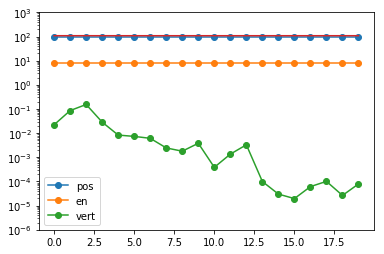

In [318]:
print(minChis)
plt.plot(minChis, 'o-')
plt.plot(minChis.sum(1))
plt.semilogy()
plt.legend(lines, ('pos', 'en', 'vert'))
plt.ylim(1e-6,1e3)

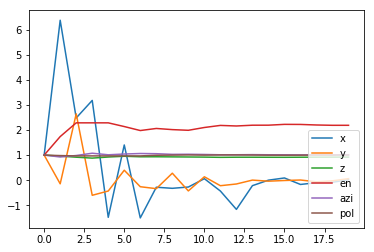

In [319]:
#print(good_params)
for v, l in zip(good_params.T, ['x', 'y', 'z', 'en', 'azi', 'pol', 'bmag']):
    plt.plot(v / v[0], label=l)
plt.legend(loc=4)

(0, 4.007906320720311)

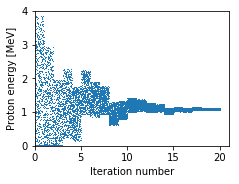

In [312]:

plt.figure(figsize=(3.5, 2.5))
plt.plot(all_params[:, :, 3].ravel(), ',')
plt.xticks(np.arange(0, mcfitter.num_pts * (mcfitter.num_iters + 1), mcfitter.num_pts * 5),
               np.arange(0, mcfitter.num_iters + 1, 5))

plt.xlabel('Iteration number')
plt.ylabel('Proton energy [MeV]')
    
plt.tight_layout(pad=0.5)
plt.subplots_adjust(right=0.9)
    
plt.xlim(0)
plt.ylim(0)


In [322]:
tracker = Tracker(mass_num, charge_num, beam_enu0, beam_mass, beam_charge, gas, efield, bfield, max_en) 
evtgen = EventGenerator(padplane, vd, 12.5, 280e-9, mass_num, 23.0, 500, 120e-15, tilt, 0.1e-3) 


num_iters = [5, 10, 15, 20]
num_pts = [100, 200, 300, 400, 500] #repeat(200)
red_factor = [0.5, 0.6, 0.7, 0.8, 0.9]

#for n, p, r in zip(num_iters, num_pts, red_factor):
#    minimizer = Minimizer(tracker, evtgen, num_iters, num_pts, red_factor)

allctrs = []
for n, p, r in zip(num_iters, num_pts, red_factor):
    ctrs = []
    for i in range(1):
        mcres, minChis, all_params, good_param_idx = mcfitter.process_event(xyz, cu, cv, return_details=True)
        good_params = all_params[good_param_idx.astype('int')]
        ctrs.append(pd.DataFrame(good_params.T, index=('x', 'y', 'z', 'en', 'azi', 'pol')))

    ctrs = pd.concat(ctrs, axis=1).T
    ctrs['num_iters'] = n
    ctrs['num_pts'] = p
    ctrs['red_factor'] = r

    allctrs.append(ctrs)

In [323]:
print(allctrs)

[               x         y         z        en       azi       pol  num_iters  \
0  -7.709319e-04 -0.003666 -0.422075  0.724414 -3.606534  1.763533          5   
1   4.865292e-04  0.001453 -0.422753  1.726137 -3.560329  1.576847          5   
2  -2.399077e-03 -0.000263 -0.453597  1.255951 -3.578420  1.608053          5   
3   5.873774e-04  0.000160 -0.449530  1.911975 -3.349591  1.540269          5   
4   4.121090e-04 -0.000291 -0.436239  1.447951 -3.226299  1.540269          5   
5  -5.034350e-04  0.000008 -0.450810  0.826029 -3.059166  1.614352          5   
6  -3.994374e-05 -0.000669 -0.437913  0.555303 -3.154466  1.606988          5   
7  -1.052012e-03  0.000336 -0.437704  0.802808 -3.117981  1.622392          5   
8  -1.054091e-05  0.000135 -0.440310  0.562844 -3.081484  1.661643          5   
9  -1.614450e-06  0.000089 -0.435482  0.820832 -3.132833  1.696411          5   
10 -2.464041e-04 -0.000005 -0.438332  0.848417 -3.136872  1.688018          5   
11  1.527990e-04 -0.000020 